# LogisticRegression

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import shap
import time
import json
import config as cfg

from category_encoders import WOEEncoder
from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

from imblearn.under_sampling import RandomUnderSampler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances

from sklearn.model_selection import (
    RepeatedStratifiedKFold,
    StratifiedKFold,
    cross_validate,
    cross_val_score
)

cv_dev = StratifiedKFold(n_splits=cfg.N_SPLITS, shuffle=True, random_state=cfg.SEED)
cv_test = RepeatedStratifiedKFold(n_splits=cfg.N_SPLITS, n_repeats=cfg.N_REPEATS, random_state=cfg.SEED)

np.set_printoptions(formatter={"float": lambda x: "{0:0.4f}".format(x)})
pd.set_option("display.max_columns", None)
warnings.filterwarnings("ignore")

sns.set_context("paper", font_scale=1.4)
sns.set_style("darkgrid")

In [2]:
MODEL_NAME = 'LogisticRegression'

In [3]:
# Load data
X_train = pd.read_csv(os.path.join("Data", "data_preprocessed_binned", "X_train.csv"))
X_test = pd.read_csv(os.path.join("Data", "data_preprocessed_binned", "X_test.csv"))
y_train = pd.read_csv(os.path.join("Data", "data_preprocessed_binned", "y_train.csv"))
y_test = pd.read_csv(os.path.join("Data", "data_preprocessed_binned", "y_test.csv"))

X_train

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr37,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64
0,"(0.0224, 0.043]","(0.64, 0.742]","(-0.169, -0.0257]","(0.0010799999999999998, 0.677]","(-11903000.001, -149.873]","(-508.121, 0.0]","(0.0275, 0.0509]","(0.538, 0.783]","(-1.2169999999999999, 0.762]","(0.342, 0.431]","(0.0681, 0.1]","(0.439, 0.748]","(0.229, 4972.0]","(0.0275, 0.051]","(1813.56, 2740.2]","(0.0906, 0.155]","(1.347, 1.561]","(0.0275, 0.051]","(0.163, 123.94]","(-0.0024400000000000003, 3.195]","(1.067, 1.153]","(0.0546, 0.0852]","(0.144, 123.94]","(-0.017, 0.0407]","(0.284, 0.378]","(0.0829, 0.141]","(1.723, 3.24]","(-0.0471, 0.104]","(4.581, 4.969]","(0.775, 2940.5]","(0.183, 60.43]","(218.715, 6674200.0]","(-1.9229999999999998, 1.593]","(0.0474, 0.216]","(0.0531, 0.0841]","(-0.0010845, 0.651]","(-2.202, 0.428]","(0.888, 13.656]","(0.166, 293.15]","(0.119, 0.196]","(0.163, 0.248]","(0.164, 165.95]","(-25113.001, 39.91]","(29.895, 38.302]",NaN,"(0.328, 0.521]","(-17.304000000000002, 3.014]","(0.00965, 0.0415]","(0.0762, 0.132]","(0.0010799999999999998, 0.443]","(-0.001, 0.0893]","(0.597, 84827.0]","(0.245, 0.552]","(0.859, 1.026]","(-751380.001, -1415.82]","(0.262, 293.15]","(0.0597, 0.107]","(0.746, 0.847]","(0.24, 7617.3]",NaN,"(9.477, 12.12]","(135.186, 197.651]","(1.802, 2.666]","(-0.0011020000000000001, 1.048]"
1,"(0.043, 0.0694]","(0.64, 0.742]","(0.37, 0.477]","(1.985, 2.532]","(41.777, 76.773]","(-508.121, 0.0]","(0.0509, 0.0816]","(0.331, 0.538]","(0.981, 1.033]","(0.243, 0.342]","(0.139, 0.19]","(0.156, 0.269]","(0.0889, 0.116]","(0.051, 0.0816]","(1813.56, 2740.2]","(0.0906, 0.155]","(1.347, 1.561]","(0.051, 0.0816]","(0.0497, 0.0729]","(44.123, 56.396]","(0.755, 0.836]","(-0.0746, 0.0]","(0.0624, 0.0918]","(-0.017, 0.0407]","(0.191, 0.284]","(0.141, 0.213]","(-2.048, 0.0]","(1.208, 2.078]","(3.509, 3.73]","(0.498, 0.775]","(0.118, 0.183]","(218.715, 6674200.0]","(-1.9229999999999998, 1.593]","(0.623, 1.33]","(-0.0079, 0.00967]","(0.933, 1.147]","(1.289, 1.855]","(0.629, 0.691]","(0.00642, 0.0189]","(1.006, 2.173]","(0.488, 288770.0]","(-0.0625, 0.0]","(130.885, 155.042]","(89.526, 119.771]","(0.445, 0.734]","(1.732, 2.507]","(81.134, 121.336]","(-0.0318, -0.00706]","(-0.0576, -0.0222]","(1.026, 1.231]","(0.266, 0.327]","(0.597, 84827.0]","(1.202, 1.501]","(2.922, 5.904]","(1692.22, 3080.44]","(0.262, 293.15]","(0.159, 0.226]","(-198.691, 0.746]","(0.24, 7617.3]","(6.196, 7.84]","(2.998, 4.045]","(105.556, 135.186]","(2.666, 3.44]","(4.059, 5.399]"
2,"(0.043, 0.0694]","(0.208, 0.297]","(0.277, 0.37]","(1.985, 2.532]","(19.874, 41.777]","(0.00014, 45.533]","(0.0509, 0.0816]","(2.291, 3.658]","(0.762, 0.981]","(0.682, 0.772]","(0.0425, 0.0681]","(0.156, 0.269]","(0.0664, 0.0889]","(0.051, 0.0816]","(805.69, 1182.04]","(0.35, 0.518]","(3.354, 4.784]","(0.051, 0.0816]","(0.0321, 0.0497]","(34.433, 44.123]","(0.955, 1.007]","(0.0295, 0.0546]","(0.0271, 0.0423]","(0.158, 0.232]","(0.672, 0.791]","(0.317, 0.47]","(0.146, 0.546]","(0.46, 0.756]","(4.332, 4.581]","(0.103, 0.157]","(0.0397, 0.0582]","(63.742, 77.522]","(4.681, 5.688]","(0.0474, 0.216]","(0.0531, 0.0841]","(1.356, 1.587]",NaN,"(0.691, 0.755]","(0.0341, 0.0523]","(0.324, 0.553]","(0.0791, 0.112]","(0.0349, 0.0534]","(113.554, 130.885]","(74.111, 89.526]","(0.261, 0.445]","(1.322, 1.732]","(37.104, 47.823]","(-0.00706, 0.00965]","(-0.00452, 0.00603]","(1.969, 2.78]","(0.206, 0.266]","(0.174, 0.212]","(1.501, 1.945]","(1.374, 1.662]","(6061.56, 14091.6]","(-0.0836, -0.00684]","(0.0597, 0.107]","(1.006, 1.078]","(-172.071, 0.0]","(7.84, 9.952]","(4.045, 4.895]","(57.998, 70.664]","(5.139, 6.258]","(3.069, 4.059]"
3,"

### Test performance

test_gini:	 0.7154
test_ap:	 0.3102


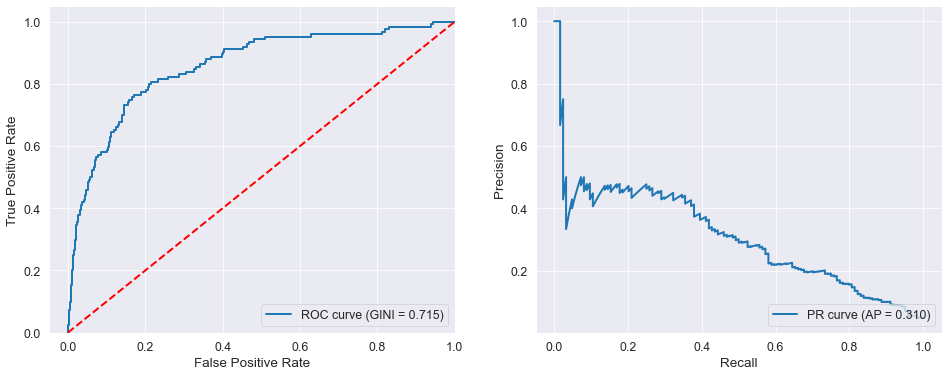

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

model = Pipeline([("encoder", WOEEncoder()), ("lr", LogisticRegression(random_state=cfg.SEED))])
model.fit(X = X_train, y = np.ravel(y_train))

# Calculate metrics
preds = model.predict_proba(X_test)[::,1]
test_gini = metrics.roc_auc_score(y_test, preds)*2-1
test_ap = metrics.average_precision_score(y_test, preds)
print(f"test_gini:\t {test_gini:.4}")
print(f"test_ap:\t {test_ap:.4}")

# ROC
test_auc = metrics.roc_auc_score(y_test, preds)

fpr, tpr, _ = metrics.roc_curve(y_test, preds)
lw = 2
axs[0].plot(fpr, tpr, lw=lw, label="ROC curve (GINI = %0.3f)" % test_gini)
axs[0].plot([0, 1], [0, 1], color="red", lw=lw, linestyle="--")
axs[0].set_xlim([-0.05, 1.0])
axs[0].set_ylim([0.0, 1.05])
axs[0].set_xlabel("False Positive Rate")
axs[0].set_ylabel("True Positive Rate")
axs[0].legend(loc="lower right")

# PR
precision, recall, _ = metrics.precision_recall_curve(y_test, preds)
lw = 2
axs[1].plot(recall, precision, lw=lw, label="PR curve (AP = %0.3f)" % test_ap)
axs[1].set_xlabel("Recall")
axs[1].set_ylabel("Precision")
axs[1].legend(loc="lower right")

plt.savefig(os.path.join("Graphs", f"ROC_PRC_{MODEL_NAME}.png"), facecolor="w", dpi=100, bbox_inches = "tight")

In [5]:
# Cross-validation GINI
scores_gini = cross_validate(
    model, X_train, np.ravel(y_train), scoring="roc_auc", cv=cv_test, return_train_score=True, n_jobs=-1
)

mean_train_gini = (scores_gini["train_score"]*2-1).mean()
mean_test_gini = (scores_gini["test_score"]*2-1).mean()
std_test_gini = (scores_gini["test_score"]*2-1).std()

print(f"mean_train_gini:\t {mean_train_gini:.4}")
print(f"mean_dev_gini:\t\t {mean_test_gini:.4} (+-{std_test_gini:.1})")

mean_train_gini:	 0.7821
mean_dev_gini:		 0.6898 (+-0.04)


### Model analysis

BAD    0.090909
dtype: float64


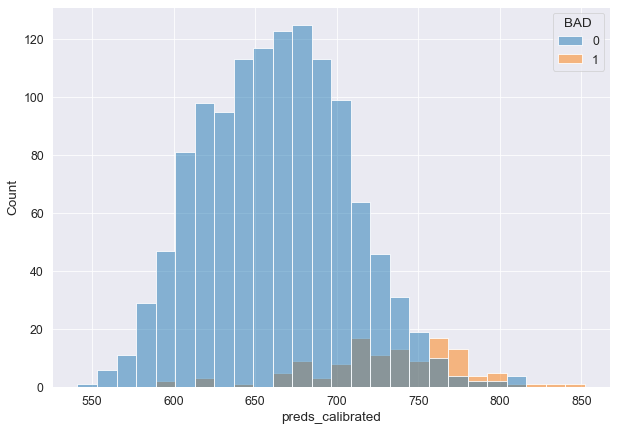

In [6]:
rus = RandomUnderSampler(sampling_strategy=cfg.SAMPLING_STRATEGY)
X_sub, y_sub = rus.fit_resample(X_test, y_test)
print(y_sub.mean())

preds = model.predict_proba(X_sub)[::,1]
preds_calibrated = pd.DataFrame(np.round(28.85*np.log(preds/(1-preds))+765.75), columns=["preds_calibrated"])

fig, axs = plt.subplots(1, 1, figsize=(10,7))
palette ={0: "C0", 1: "C1"}
sns.histplot(data=preds_calibrated, x="preds_calibrated", hue=y_sub['BAD'], palette=palette, ax=axs, bins='auto')

plt.savefig(os.path.join("Graphs", f"Score_distr_{MODEL_NAME}.png"), facecolor="w", dpi=100, bbox_inches = "tight")

In [7]:
# Logistic regression coefficients
coefs = pd.DataFrame(
    zip(X_train.columns, model["lr"].coef_[0]), columns=["Variable", "Coef"]
)
coefs_sorted = coefs.reindex(coefs["Coef"].abs().sort_values(ascending=False).index)
coefs_sorted

,Variable,Coef
57,Attr58,-1.518373
15,Attr16,-1.196872
26,Attr27,1.083489
32,Attr33,-1.061842
18,Attr19,-1.009690
...,...,...
7,Attr8,0.047465
50,Attr51,-0.035896
14,Attr15,-0.033889
6,Attr7,-0.014749


In [8]:
# Save results for final summary
results = {
    "test_gini": test_gini,
    "test_ap": test_ap,
    "optimization_time": 0,
    "fpr": fpr.tolist(),
    "tpr": tpr.tolist(),
    "precision": precision.tolist(),
    "recall": recall.tolist(),
    "mean_train_gini": scores_gini["train_score"].tolist(),
    "mean_test_gini": scores_gini["test_score"].tolist(),
}

with open(os.path.join("Results", f"Results_{MODEL_NAME}.json"), 'w') as fp:
    json.dump(results, fp)